In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import glob as gb
import cv2
import keras
import io
import typing
from keras import backend as K
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Dropout, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle
import itertools 

#Model Graphs
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
!pip install split-folders

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [3]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/kaggle/input/plantvillage-dataset/color/", output="./new",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 54305 files [09:14, 97.95 files/s] 


In [4]:
train_path='/kaggle/working/new/train/'
test_path='/kaggle/working/new/test/'
val_path='/kaggle/working/new/val/'

In [5]:
traingen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
testgen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
validgen =tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

In [6]:
train_ds=traingen.flow_from_directory(batch_size=64,directory=train_path,shuffle=True,
                                                 target_size=(128, 128),class_mode='categorical')
test_ds=traingen.flow_from_directory(batch_size=64,directory=test_path,shuffle=False,target_size=(128, 128), 
                                                 class_mode='categorical')

val_ds=traingen.flow_from_directory(batch_size=64,directory=val_path,shuffle=True,target_size=(128, 128), 
                                                 class_mode='categorical')

Found 43429 images belonging to 38 classes.
Found 5459 images belonging to 38 classes.
Found 5417 images belonging to 38 classes.


In [7]:
class LayerScale(layers.Layer):
    """LayerScale as introduced in CaiT: https://arxiv.org/abs/2103.17239.

    Args:
        init_values (float): value to initialize the diagonal matrix of LayerScale.
        projection_dim (int): projection dimension used in LayerScale.
    """

    def __init__(self, init_values: float, projection_dim: int, **kwargs):
        super().__init__(**kwargs)
        self.gamma = tf.Variable(init_values * tf.ones((projection_dim,)))

    def call(self, x, training=False):
        return x * self.gamma

In [8]:


class StochasticDepth(layers.Layer):
    """Stochastic Depth layer (https://arxiv.org/abs/1603.09382).

    Reference:
        https://github.com/rwightman/pytorch-image-models
    """

    def __init__(self, drop_prob: float, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x, training=False):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x



In [9]:
class ClassAttention(layers.Layer):
    """Class attention as proposed in CaiT: https://arxiv.org/abs/2103.17239.

    Args:
        projection_dim (int): projection dimension for the query, key, and value
            of attention.
        num_heads (int): number of attention heads.
        dropout_rate (float): dropout rate to be used for dropout in the attention
            scores as well as the final projected outputs.
    """

    def __init__(
        self, projection_dim: int, num_heads: int, dropout_rate: float, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_heads = num_heads

        head_dim = projection_dim // num_heads
        self.scale = head_dim**-0.5

        self.q = layers.Dense(projection_dim)
        self.k = layers.Dense(projection_dim)
        self.v = layers.Dense(projection_dim)
        self.attn_drop = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(projection_dim)
        self.proj_drop = layers.Dropout(dropout_rate)

    def call(self, x, training=False):
        batch_size, num_patches, num_channels = (
            tf.shape(x)[0],
            tf.shape(x)[1],
            tf.shape(x)[2],
        )

        # Query projection. `cls_token` embeddings are queries.
        q = tf.expand_dims(self.q(x[:, 0]), axis=1)
        q = tf.reshape(
            q, (batch_size, 1, self.num_heads, num_channels // self.num_heads)
        )  # Shape: (batch_size, 1, num_heads, dimension_per_head)
        q = tf.transpose(q, perm=[0, 2, 1, 3])
        scale = tf.cast(self.scale, dtype=q.dtype)
        q = q * scale

        # Key projection. Patch embeddings as well the cls embedding are used as keys.
        k = self.k(x)
        k = tf.reshape(
            k, (batch_size, num_patches, self.num_heads, num_channels // self.num_heads)
        )  # Shape: (batch_size, num_tokens, num_heads, dimension_per_head)
        k = tf.transpose(k, perm=[0, 2, 1, 3])

        # Value projection. Patch embeddings as well the cls embedding are used as values.
        v = self.v(x)
        v = tf.reshape(
            v, (batch_size, num_patches, self.num_heads, num_channels // self.num_heads)
        )
        v = tf.transpose(v, perm=[0, 2, 1, 3])

        # Calculate attention scores between cls_token embedding and patch embeddings.
        attn = tf.matmul(q, k, transpose_b=True)
        attn = tf.nn.softmax(attn, axis=-1)
        attn = self.attn_drop(attn, training)

        x_cls = tf.matmul(attn, v)
        x_cls = tf.transpose(x_cls, perm=[0, 2, 1, 3])
        x_cls = tf.reshape(x_cls, (batch_size, 1, num_channels))
        x_cls = self.proj(x_cls)
        x_cls = self.proj_drop(x_cls, training)

        return x_cls, attn

In [10]:
class TalkingHeadAttention(layers.Layer):
    """Talking-head attention as proposed in CaiT: https://arxiv.org/abs/2003.02436.

    Args:
        projection_dim (int): projection dimension for the query, key, and value
            of attention.
        num_heads (int): number of attention heads.
        dropout_rate (float): dropout rate to be used for dropout in the attention
            scores as well as the final projected outputs.
    """

    def __init__(
        self, projection_dim: int, num_heads: int, dropout_rate: float, **kwargs
    ):
        super().__init__(**kwargs)

        self.num_heads = num_heads

        head_dim = projection_dim // self.num_heads

        self.scale = head_dim**-0.5

        self.qkv = layers.Dense(projection_dim * 3)
        self.attn_drop = layers.Dropout(dropout_rate)

        self.proj = layers.Dense(projection_dim)

        self.proj_l = layers.Dense(self.num_heads)
        self.proj_w = layers.Dense(self.num_heads)

        self.proj_drop = layers.Dropout(dropout_rate)

    def call(self, x, training=False):
        B, N, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]

        # Project the inputs all at once.
        qkv = self.qkv(x)

        # Reshape the projected output so that they're segregated in terms of
        # query, key, and value projections.
        qkv = tf.reshape(qkv, (B, N, 3, self.num_heads, C // self.num_heads))

        # Transpose so that the `num_heads` becomes the leading dimensions.
        # Helps to better segregate the representation sub-spaces.
        qkv = tf.transpose(qkv, perm=[2, 0, 3, 1, 4])
        scale = tf.cast(self.scale, dtype=qkv.dtype)
        q, k, v = qkv[0] * scale, qkv[1], qkv[2]

        # Obtain the raw attention scores.
        attn = tf.matmul(q, tf.transpose(k, perm=[0, 1, 3, 2]))

        # Linear projection of the similarities between the query and key projections.
        attn = self.proj_l(tf.transpose(attn, perm=[0, 2, 3, 1]))

        # Normalize the attention scores.
        attn = tf.transpose(attn, perm=[0, 3, 1, 2])
        attn = tf.nn.softmax(attn, axis=-1)

        # Linear projection on the softmaxed scores.
        attn = self.proj_w(tf.transpose(attn, perm=[0, 2, 3, 1]))
        attn = tf.transpose(attn, perm=[0, 3, 1, 2])
        attn = self.attn_drop(attn, training)

        # Final set of projections as done in the vanilla attention mechanism.
        x = tf.matmul(attn, v)
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        x = tf.reshape(x, (B, N, C))

        x = self.proj(x)
        x = self.proj_drop(x, training)

        return x, attn

In [11]:
def mlp(x, dropout_rate: float, hidden_units: typing.List[int]):
    """FFN for a Transformer block."""
    for (idx, units) in enumerate(hidden_units):
        x = layers.Dense(
            units,
            activation=tf.nn.gelu if idx == 0 else None,
            bias_initializer=keras.initializers.RandomNormal(stddev=1e-6),
        )(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [12]:
def LayerScaleBlockClassAttention(
    projection_dim: int,
    num_heads: int,
    layer_norm_eps: float,
    init_values: float,
    mlp_units: typing.List[int],
    dropout_rate: float,
    sd_prob: float,
    name: str,
):
    """Pre-norm transformer block meant to be applied to the embeddings of the
    cls token and the embeddings of image patches.

    Includes LayerScale and Stochastic Depth.

    Args:
        projection_dim (int): projection dimension to be used in the
            Transformer blocks and patch projection layer.
        num_heads (int): number of attention heads.
        layer_norm_eps (float): epsilon to be used for Layer Normalization.
        init_values (float): initial value for the diagonal matrix used in LayerScale.
        mlp_units (List[int]): dimensions of the feed-forward network used in
            the Transformer blocks.
        dropout_rate (float): dropout rate to be used for dropout in the attention
            scores as well as the final projected outputs.
        sd_prob (float): stochastic depth rate.
        name (str): a name identifier for the block.

    Returns:
        A keras.Model instance.
    """
    x = keras.Input((None, projection_dim))
    x_cls = keras.Input((None, projection_dim))
    inputs = keras.layers.Concatenate(axis=1)([x_cls, x])

    # Class attention (CA).
    x1 = layers.LayerNormalization(epsilon=layer_norm_eps)(inputs)
    attn_output, attn_scores = ClassAttention(projection_dim, num_heads, dropout_rate)(
        x1
    )
    attn_output = (
        LayerScale(init_values, projection_dim)(attn_output)
        if init_values
        else attn_output
    )
    attn_output = StochasticDepth(sd_prob)(attn_output) if sd_prob else attn_output
    x2 = keras.layers.Add()([x_cls, attn_output])

    # FFN.
    x3 = layers.LayerNormalization(epsilon=layer_norm_eps)(x2)
    x4 = mlp(x3, hidden_units=mlp_units, dropout_rate=dropout_rate)
    x4 = LayerScale(init_values, projection_dim)(x4) if init_values else x4
    x4 = StochasticDepth(sd_prob)(x4) if sd_prob else x4
    outputs = keras.layers.Add()([x2, x4])

    return keras.Model([x, x_cls], [outputs, attn_scores], name=name)


def LayerScaleBlock(
    projection_dim: int,
    num_heads: int,
    layer_norm_eps: float,
    init_values: float,
    mlp_units: typing.List[int],
    dropout_rate: float,
    sd_prob: float,
    name: str,
):
    """Pre-norm transformer block meant to be applied to the embeddings of the
    image patches.

    Includes LayerScale and Stochastic Depth.

        Args:
            projection_dim (int): projection dimension to be used in the
                Transformer blocks and patch projection layer.
            num_heads (int): number of attention heads.
            layer_norm_eps (float): epsilon to be used for Layer Normalization.
            init_values (float): initial value for the diagonal matrix used in LayerScale.
            mlp_units (List[int]): dimensions of the feed-forward network used in
                the Transformer blocks.
            dropout_rate (float): dropout rate to be used for dropout in the attention
                scores as well as the final projected outputs.
            sd_prob (float): stochastic depth rate.
            name (str): a name identifier for the block.

    Returns:
        A keras.Model instance.
    """
    encoded_patches = keras.Input((None, projection_dim))

    # Self-attention.
    x1 = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    attn_output, attn_scores = TalkingHeadAttention(
        projection_dim, num_heads, dropout_rate
    )(x1)
    attn_output = (
        LayerScale(init_values, projection_dim)(attn_output)
        if init_values
        else attn_output
    )
    attn_output = StochasticDepth(sd_prob)(attn_output) if sd_prob else attn_output
    x2 = layers.Add()([encoded_patches, attn_output])

    # FFN.
    x3 = layers.LayerNormalization(epsilon=layer_norm_eps)(x2)
    x4 = mlp(x3, hidden_units=mlp_units, dropout_rate=dropout_rate)
    x4 = LayerScale(init_values, projection_dim)(x4) if init_values else x4
    x4 = StochasticDepth(sd_prob)(x4) if sd_prob else x4
    outputs = layers.Add()([x2, x4])

    return keras.Model(encoded_patches, [outputs, attn_scores], name=name)

In [13]:
class CaiT(keras.Model):
    """CaiT model.

    Args:
        projection_dim (int): projection dimension to be used in the
            Transformer blocks and patch projection layer.
        patch_size (int): patch size of the input images.
        num_patches (int): number of patches after extracting the image patches.
        init_values (float): initial value for the diagonal matrix used in LayerScale.
        mlp_units: (List[int]): dimensions of the feed-forward network used in
            the Transformer blocks.
        sa_ffn_layers (int): number of self-attention Transformer blocks.
        ca_ffn_layers (int): number of class-attention Transformer blocks.
        num_heads (int): number of attention heads.
        layer_norm_eps (float): epsilon to be used for Layer Normalization.
        dropout_rate (float): dropout rate to be used for dropout in the attention
            scores as well as the final projected outputs.
        sd_prob (float): stochastic depth rate.
        global_pool (str): denotes how to pool the representations coming out of
            the final Transformer block.
        pre_logits (bool): if set to True then don't add a classification head.
        num_classes (int): number of classes to construct the final classification
            layer with.
    """

    def __init__(
        self,
        projection_dim: int,
        patch_size: int,
        num_patches: int,
        init_values: float,
        mlp_units: typing.List[int],
        sa_ffn_layers: int,
        ca_ffn_layers: int,
        num_heads: int,
        layer_norm_eps: float,
        dropout_rate: float,
        sd_prob: float,
        global_pool: str,
        pre_logits: bool,
        num_classes: int,
        **kwargs,
    ):
        if global_pool not in ["token", "avg"]:
            raise ValueError(
                'Invalid value received for `global_pool`, should be either `"token"` or `"avg"`.'
            )

        super().__init__(**kwargs)

        # Responsible for patchifying the input images and the linearly projecting them.
        self.projection = keras.Sequential(
            [
                layers.Conv2D(
                    filters=projection_dim,
                    kernel_size=(patch_size, patch_size),
                    strides=(patch_size, patch_size),
                    padding="VALID",
                    name="conv_projection",
                    kernel_initializer="lecun_normal",
                ),
                layers.Reshape(
                    target_shape=(-1, projection_dim),
                    name="flatten_projection",
                ),
            ],
            name="projection",
        )

        # CLS token and the positional embeddings.
        self.cls_token = tf.Variable(tf.zeros((1, 1, projection_dim)))
        self.pos_embed = tf.Variable(tf.zeros((1, num_patches, projection_dim)))

        # Projection dropout.
        self.pos_drop = layers.Dropout(dropout_rate, name="projection_dropout")

        # Stochastic depth schedule.
        dpr = [sd_prob for _ in range(sa_ffn_layers)]

        # Self-attention (SA) Transformer blocks operating only on the image patch
        # embeddings.
        self.blocks = [
            LayerScaleBlock(
                projection_dim=projection_dim,
                num_heads=num_heads,
                layer_norm_eps=layer_norm_eps,
                init_values=init_values,
                mlp_units=mlp_units,
                dropout_rate=dropout_rate,
                sd_prob=dpr[i],
                name=f"sa_ffn_block_{i}",
            )
            for i in range(sa_ffn_layers)
        ]

        # Class Attention (CA) Transformer blocks operating on the CLS token and image patch
        # embeddings.
        self.blocks_token_only = [
            LayerScaleBlockClassAttention(
                projection_dim=projection_dim,
                num_heads=num_heads,
                layer_norm_eps=layer_norm_eps,
                init_values=init_values,
                mlp_units=mlp_units,
                dropout_rate=dropout_rate,
                name=f"ca_ffn_block_{i}",
                sd_prob=0.0,  # No Stochastic Depth in the class attention layers.
            )
            for i in range(ca_ffn_layers)
        ]

        # Pre-classification layer normalization.
        self.norm = layers.LayerNormalization(epsilon=layer_norm_eps, name="head_norm")

        # Representation pooling for classification head.
        self.global_pool = global_pool

        # Classification head.
        self.pre_logits = pre_logits
        self.num_classes = num_classes
        
        self.head = layers.Dense(num_classes, name="classification_head")

    def call(self, x, training=False):
        # Notice how CLS token is not added here.
        
        x = self.projection(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # SA+FFN layers.
        sa_ffn_attn = {}
        for blk in self.blocks:
            x, attn_scores = blk(x)
            sa_ffn_attn[f"{blk.name}_att"] = attn_scores

        # CA+FFN layers.
        ca_ffn_attn = {}
        cls_tokens = tf.tile(self.cls_token, (tf.shape(x)[0], 1, 1))
        for blk in self.blocks_token_only:
            cls_tokens, attn_scores = blk([x, cls_tokens])
            ca_ffn_attn[f"{blk.name}_att"] = attn_scores

        x = tf.concat([cls_tokens, x], axis=1)
        x = self.norm(x)

        # Always return the attention scores from the SA+FFN and CA+FFN layers
        # for convenience.
        if self.global_pool:
            x = (
                tf.reduce_mean(x[:, 1:], axis=1)
                if self.global_pool == "avg"
                else x[:, 0]
            )
        return (self.head(x))

In [14]:


def get_config(
    image_size: int = 128,
    patch_size: int = 16,
    projection_dim: int = 192,
    sa_ffn_layers: int = 24,
    ca_ffn_layers: int = 2,
    num_heads: int = 4,
    mlp_ratio: int = 4,
    layer_norm_eps=1e-6,
    init_values: float = 1e-5,
    dropout_rate: float = 0.0,
    sd_prob: float = 0.0,
    global_pool: str = "token",
    pre_logits: bool = True,
    num_classes: int = 38,
) -> typing.Dict:
    """Default configuration for CaiT models (cait_xxs24_224).

    Reference:
        https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/cait.py
    """
    config = {}

    # Patchification and projection.
    config["patch_size"] = patch_size
    config["num_patches"] = (image_size // patch_size) ** 2

    # LayerScale.
    config["init_values"] = init_values

    # Dropout and Stochastic Depth.
    config["dropout_rate"] = dropout_rate
    config["sd_prob"] = sd_prob

    # Shared across different blocks and layers.
    config["layer_norm_eps"] = layer_norm_eps
    config["projection_dim"] = projection_dim
    config["mlp_units"] = [
        projection_dim * mlp_ratio,
        projection_dim,
    ]

    # Attention layers.
    config["num_heads"] = num_heads
    config["sa_ffn_layers"] = sa_ffn_layers
    config["ca_ffn_layers"] = ca_ffn_layers

    # Representation pooling and task specific parameters.
    config["global_pool"] = global_pool
    config["pre_logits"] = pre_logits
    config["num_classes"] = num_classes

    return config



In [15]:
config = get_config()
model = CaiT(**config)

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [17]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),optimizer='adam',
    metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")],
)

In [18]:
history = model.fit(train_ds, steps_per_epoch=len(train_ds),validation_data=val_ds, 
                    validation_steps=len(val_ds),epochs=50,callbacks=[callback],
                    verbose=1 )

Epoch 1/50
679/679 [==============================] - 315s 411ms/step - loss: 1.8443 - accuracy: 0.4858 - val_loss: 0.8015 - val_accuracy: 0.7536
Epoch 2/50
679/679 [==============================] - 272s 399ms/step - loss: 0.6142 - accuracy: 0.8057 - val_loss: 0.4522 - val_accuracy: 0.8534
Epoch 3/50
679/679 [==============================] - 271s 399ms/step - loss: 0.4093 - accuracy: 0.8668 - val_loss: 0.3949 - val_accuracy: 0.8710
Epoch 4/50
679/679 [==============================] - 271s 399ms/step - loss: 0.3181 - accuracy: 0.8958 - val_loss: 0.3666 - val_accuracy: 0.8809
Epoch 5/50
679/679 [==============================] - 271s 398ms/step - loss: 0.2723 - accuracy: 0.9086 - val_loss: 0.2770 - val_accuracy: 0.9118
Epoch 6/50
679/679 [==============================] - 271s 398ms/step - loss: 0.2395 - accuracy: 0.9182 - val_loss: 0.2563 - val_accuracy: 0.9203
Epoch 7/50
679/679 [==============================] - 270s 398ms/step - loss: 0.2062 - accuracy: 0.9312 - val_loss: 0.3232 -

In [19]:
from tensorflow.keras.utils import to_categorical
y_pred = model.predict_generator(test_ds)
y_pred2= to_categorical(np.argmax(y_pred, axis=1), 38)

y_test= to_categorical(test_ds.labels, 38)

# Using it in AUC
y_pred1=(np.argmax(y_pred, axis=1))
y_test1=(np.argmax(y_test, axis=1))

In [20]:
# Computing the Accuracy Score  : ((TP + TN) / float(TP + TN + FP + FN))
def Accuracy(y_test , y_pred):
    AccScore = accuracy_score(y_test, y_pred, normalize=True)
    return AccScore

In [21]:
#Computing the Precision metric (Some times called Specificity): #(True Positives / float(True Positives + False Posivites))  
def macro_precision(y_test , y_pred):
    PrecisionScore = precision_score(y_test, y_pred, average='macro') 
    return PrecisionScore

In [22]:
#Computing the Recall Score : (Some times called Sensitivity) (TP / float(TP + FN))   1 / 1+2  
def macro_recall(y_test , y_pred):
    RecallScore = recall_score(y_test, y_pred, average='macro') 
    return  RecallScore

In [23]:
#Computing the F1 Score  : 2 * (precision * recall) / (precision + recall)
def macro_F1Score(y_test , y_pred):
    F1Score = f1_score(y_test, y_pred, average='macro') 
    return F1Score

In [24]:
from sklearn.metrics import roc_auc_score

# Calculating Area under the curve
def AUC(actual_class, pred_class, average = "micro"):
    
    #Making a set of all the unique classes 
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #Making a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #Making the current class with label 1 and all other classes as a label 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # Calculating the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [25]:
print("***** Model Evaluations Details ******** \n")
print("Test loss, Test acc : " , model.evaluate_generator(test_ds)) 
print("******************************")
print("Accurayc  : " , Accuracy(test_ds.classes , y_pred1)) 
print("******************************")
print("Precision Score is : " , macro_precision(test_ds.classes , y_pred1))
print("******************************")
print("Recall Scores is : " , macro_recall(test_ds.classes , y_pred1))
print("******************************")
print('F1 Score is : ', macro_F1Score(test_ds.classes , y_pred1))
print("******************************")
print('AUC Score is : ' , AUC(test_ds.classes, y_pred1))

***** Model Evaluations Details ******** 

Test loss, Test acc :  [0.1761564314365387, 0.9532881379127502]
******************************
Accurayc  :  0.9532881480124565
******************************
Precision Score is :  0.9348505079660224
******************************
Recall Scores is :  0.9249009435571346
******************************
F1 Score is :  0.9283295005922177
******************************
AUC Score is :  {0: 0.9513616788449998, 1: 0.9516396625366232, 2: 0.8923968224741562, 3: 0.9665722201234102, 4: 0.9962177545327058, 5: 0.9620773398094526, 6: 0.9883720930232558, 7: 0.8264607133203397, 8: 0.9958333333333333, 9: 0.9436048922056385, 10: 0.9999064020965931, 11: 0.9654463869204966, 12: 0.9840137664304646, 13: 0.985958158278316, 14: 0.9532114149290646, 15: 0.9887228537758835, 16: 0.9773029508109845, 17: 0.9992624008851189, 18: 0.9744076591309746, 19: 0.97221274283042, 20: 0.9897200970330285, 21: 0.9742535920880762, 22: 0.7496325555759692, 23: 0.9605263157894737, 24: 0.983777

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
plt.style.library['seaborn-whitegrid']

RcParams({'axes.axisbelow': True,
          'axes.edgecolor': '.8',
          'axes.facecolor': 'white',
          'axes.grid': True,
          'axes.labelcolor': '.15',
          'axes.linewidth': 1.0,
          'figure.facecolor': 'white',
          'font.family': ['sans-serif'],
          'font.sans-serif': ['Arial',
                              'Liberation Sans',
                              'DejaVu Sans',
                              'Bitstream Vera Sans',
                              'sans-serif'],
          'grid.color': '.8',
          'grid.linestyle': '-',
          'image.cmap': 'Greys',
          'legend.frameon': False,
          'legend.numpoints': 1,
          'legend.scatterpoints': 1,
          'lines.solid_capstyle': <CapStyle.round: 'round'>,
          'text.color': '.15',
          'xtick.color': '.15',
          'xtick.direction': 'out',
          'xtick.major.size': 0.0,
          'xtick.minor.size': 0.0,
          'ytick.color': '.15',
          'ytick.direct

In [27]:
def plot_roc_curve(y_test,y_pred):
    n_classes=38
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw=2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot(fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,)

    plt.plot(fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)
    colors = cycle(["aqua", "darkorange", "cornflowerblue",'#9e9e9e','#b19a7e','#CD5C5C','#DFFF00',
                   '#DE3163','#ff4d4d','#CCCCFF','#800080','#4F1D25','#ccffcc','#ff0040'
                   ,'#4000ff','#0080ff','#ff8000','#666600','#b37700','#00b3b3','#003300','#FFC300','#A6F7BD',
                   '#A6BDF7','#CAA6F7','#F7A6AC','#ADF7A6','#F5F7A6','#F7CCA6','#EE4949',
                    '#DEA41F','#334471','#33716F','#343371','#772CE3','#B8BF20','#666B01','#0B6B01',
                    '#F4B708','#179690'
                   ])

    for i, color in zip(range(n_classes), colors):
        plt.plot(
           fpr[i],
           tpr[i],
           color=color,
           lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Compact Roc Curve")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

In [28]:
def Acc_Loss_Graph(history):
    # converting hsitory to dataframe
    pd.DataFrame(history.history)

    pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')

    pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

In [29]:
labels=np.array(["Class 0","Class 1","Class 2","Class 3","Class 4","Class 5","Class 6","Class 7","Class 8","Class 9","Class 10","Class 11","Class 12","Class 13","Class 14","Class 15","Class 16","Class 17",
                "Class 18","Class 19","Class 20","Class 21","Class 22","Class 23","Class 24","Class 25","Class 26","Class 27","Class 28","Class 29","Class 30","Class 31","Class 32","Class 33","Class 34"
                ,"Class 35","Class 36","Class 37"])

In [30]:
def Confusion_Matrix(y_test , y_pred):
    fig, ax = plt.subplots(figsize=(20,20))

    #cnf_matrix = confusion_matrix()
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,display_labels=labels,ax=ax,xticks_rotation='vertical'
                                                  ,cmap="Blues")

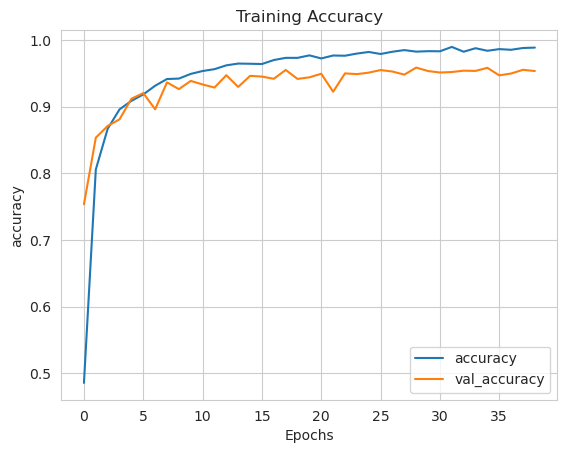

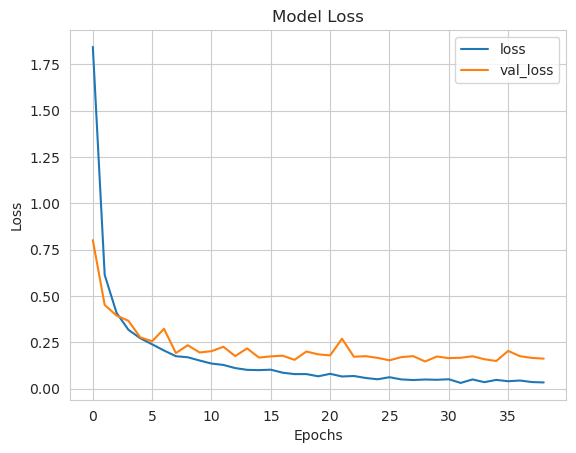

In [31]:
Acc_Loss_Graph(history)

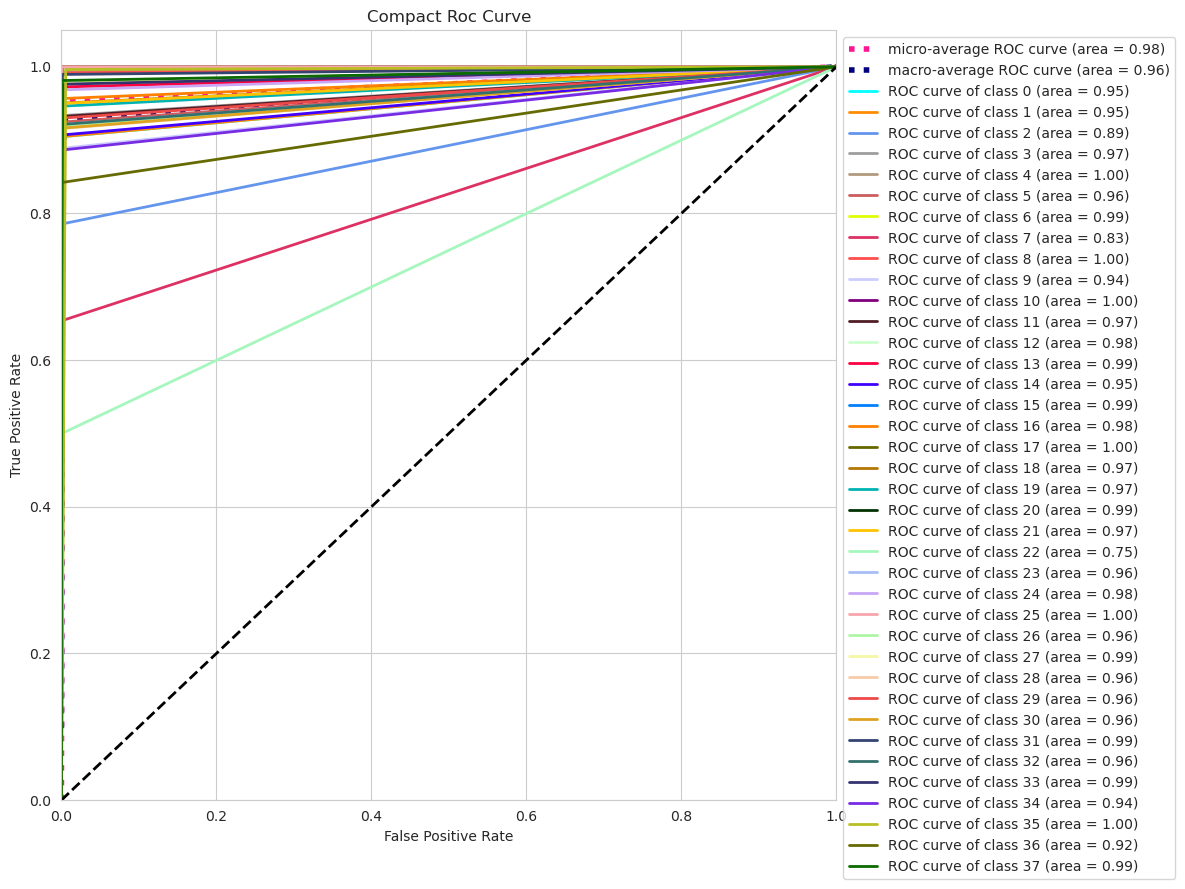

In [32]:
plot_roc_curve(y_test,y_pred2)

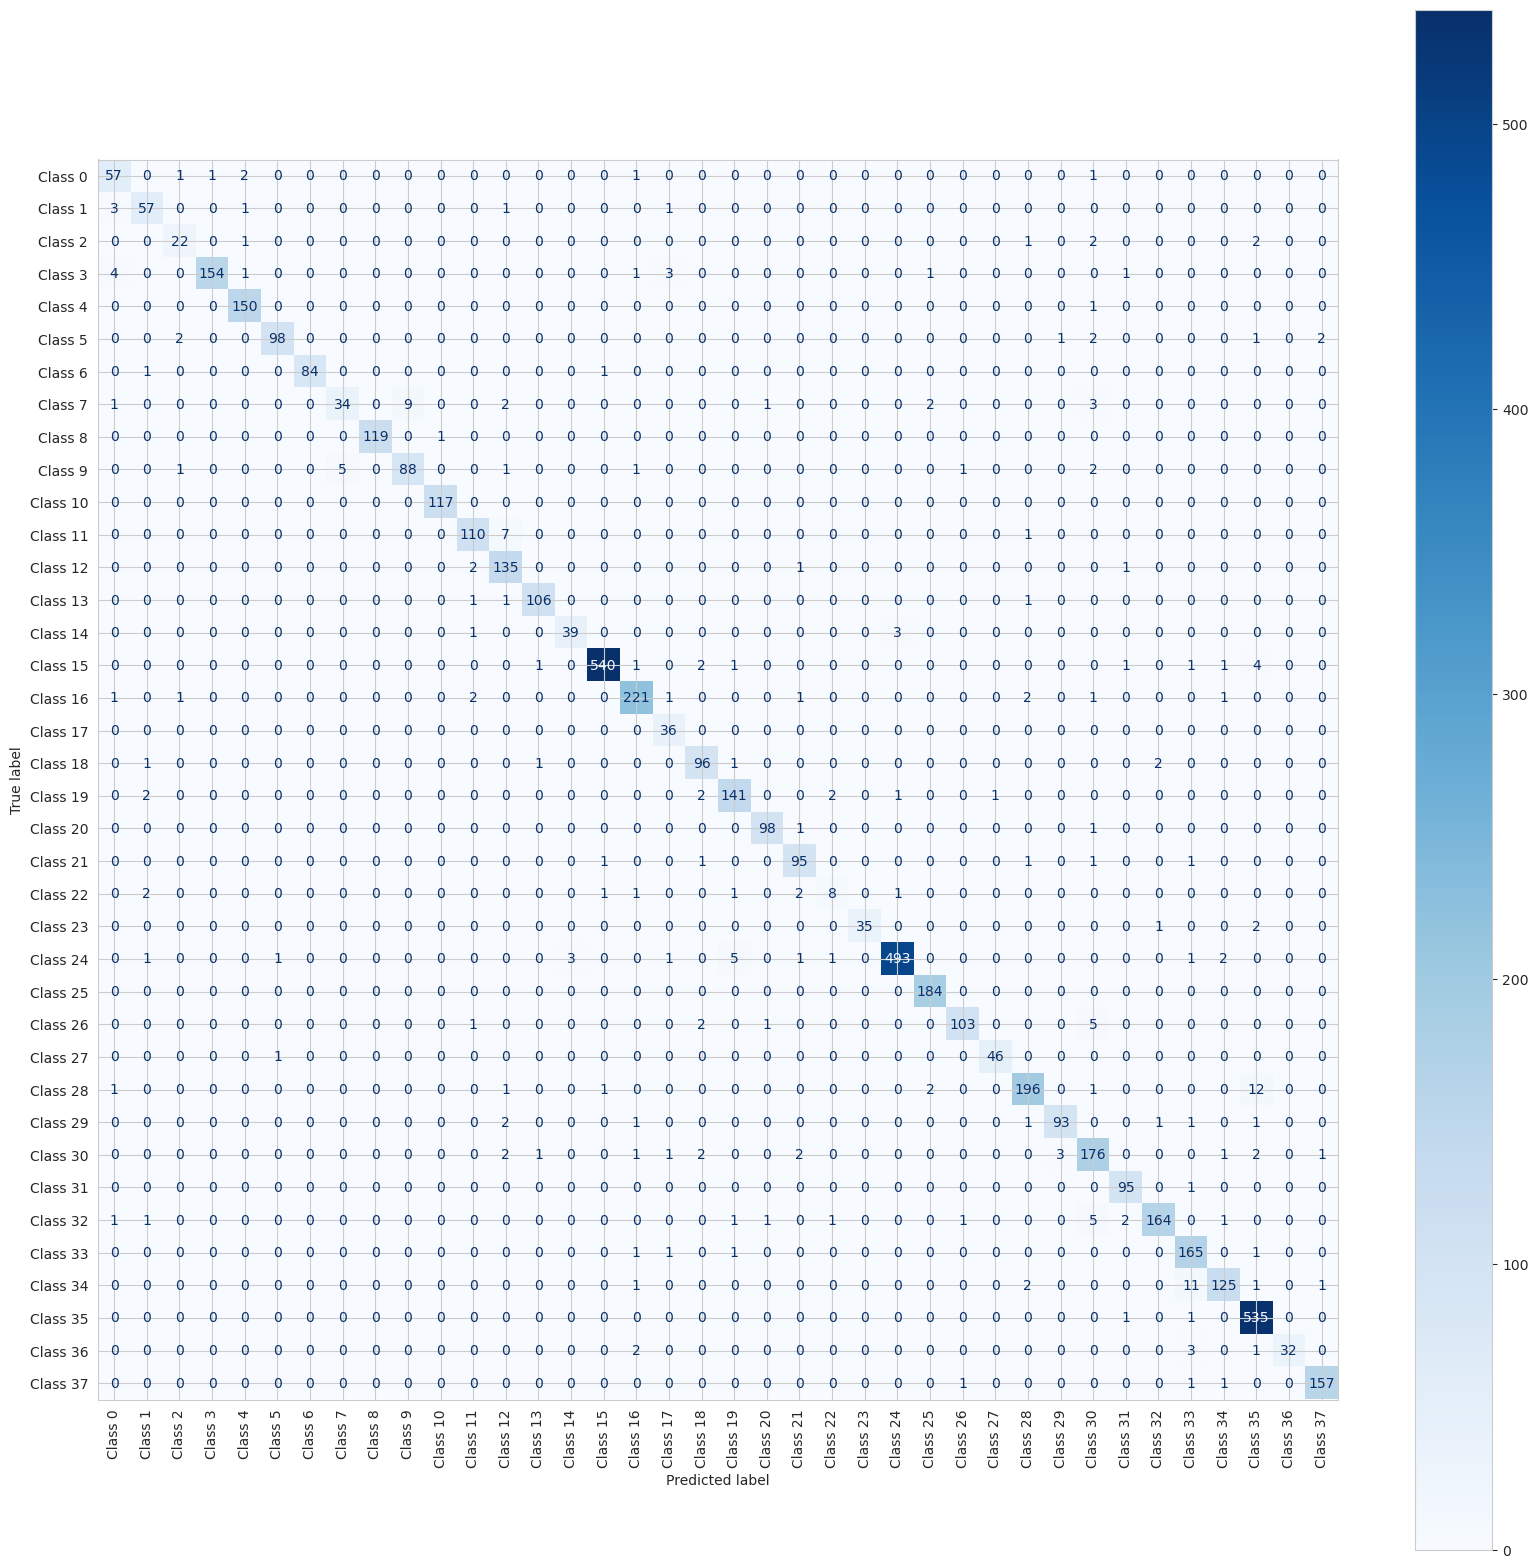

In [33]:
Confusion_Matrix(test_ds.classes , y_pred1)

In [34]:
target_name={0:"Class 0",1:"Class 1",2:"Class 2",3:"Class 3",4:"Class 4",5:"Class 5",6:"Class 6",7:"Class 7",8:"Class 8",9:"Class 9",
             10:"Class 10",11:"Class 11",12:"Class 12",
               13:"Class 13",14:"Class 14",15:"Class 15",16:"Class 16",17:"Class 17",18:"Class 18",19:"Class 19",20:"Class 20",21:"Class 21",
             22:"Class 22",23:"Class 23",24:"Class 24",25:"Class 25",26:"Class 26",27:"Class 27",28:"Class 28",29:"Class 29",30:"Class 30",31:"Class 31",32:"Class 32",33:"Class 33",34:"Class 34"
                ,35:"Class 35",36:"Class 36",37:"Class 37"}

In [35]:
from sklearn.manifold import TSNE
tsne1 = TSNE(random_state = 42, n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(y_pred)

In [36]:
# create dataframe
cps_df = pd.DataFrame(columns=['CP1', 'CP2', 'target'],
                       data=np.column_stack((tsne1, 
                                            y_test1)))# cast targets column to int
cps_df.loc[:, 'target'] = cps_df.target.astype(int)
cps_df.loc[:, 'target'] = cps_df.target.map(target_name)

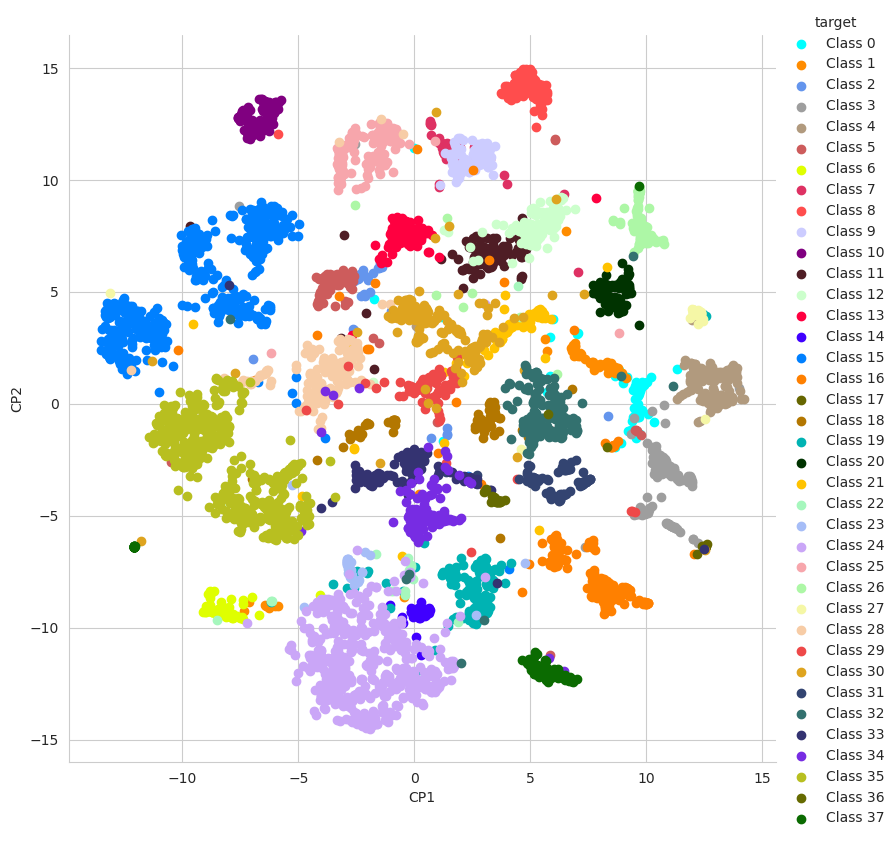

In [37]:
import seaborn as sns
d = {'color': ["aqua", "darkorange", "cornflowerblue",'#9e9e9e','#b19a7e','#CD5C5C','#DFFF00',
                   '#DE3163','#ff4d4d','#CCCCFF','#800080','#4F1D25','#ccffcc','#ff0040'
                   ,'#4000ff','#0080ff','#ff8000','#666600','#b37700','#00b3b3','#003300','#FFC300','#A6F7BD',
                   '#A6BDF7','#CAA6F7','#F7A6AC','#ADF7A6','#F5F7A6','#F7CCA6','#EE4949',
                    '#DEA41F','#334471','#33716F','#343371','#772CE3','#B8BF20','#666B01','#0B6B01',
                    '#F4B708','#179690'] }
grid = sns.FacetGrid(cps_df, hue="target",hue_kws=d, height=8)
grid.map(plt.scatter, 'CP1', 'CP2').add_legend()

In [38]:
from sklearn.manifold import TSNE
tsne3 = TSNE(random_state = 42, n_components=3, verbose=0, perplexity=40, n_iter=500).fit_transform(y_pred)

In [39]:
cps_df2 = pd.DataFrame(columns=['CP1', 'CP2','CP3', 'target'],
                       data=np.column_stack((tsne3, 
                                            y_test1)))# cast targets column to int
cps_df2.loc[:, 'target'] = cps_df2.target.astype(int)

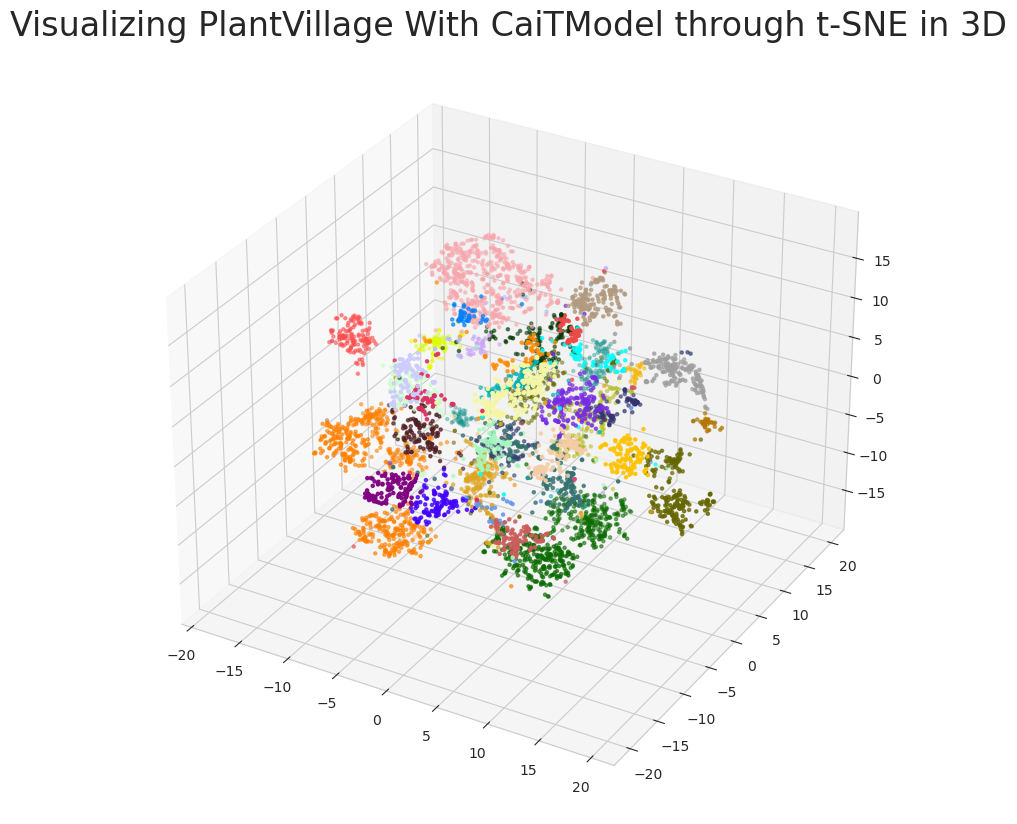

In [40]:
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.colors as mcolors
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

sc=ax.scatter(tsne3[:, 0], tsne3[:, 1],tsne3[:,2], s=5, c=y_test1, cmap=mcolors.ListedColormap(["aqua", "darkorange", "cornflowerblue",'#9e9e9e','#b19a7e','#CD5C5C','#DFFF00',
                   '#DE3163','#ff4d4d','#CCCCFF','#800080','#4F1D25','#ccffcc','#ff0040'
                   ,'#4000ff','#0080ff','#ff8000','#666600','#b37700','#00b3b3','#003300','#FFC300','#A6F7BD',
                   '#A6BDF7','#CAA6F7','#F7A6AC','#ADF7A6','#F5F7A6','#F7CCA6','#EE4949',
                    '#DEA41F','#334471','#33716F','#343371','#772CE3','#B8BF20','#666B01','#0B6B01',
                    '#F4B708','#179690']))
plt.title('Visualizing PlantVillage With CaiTModel through t-SNE in 3D', fontsize=24);
plt.show()

In [41]:
model.save('model',save_format='tf')